In [1]:
import networkx as nx
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# read data

In [2]:
nodes_entities = pd.read_csv("./data/nodes-entities.csv", low_memory=False, index_col=0)
nodes_entities["node_type"] = ["Entity"]*len(nodes_entities)

nodes_intermediaries = pd.read_csv("./data/nodes-intermediaries.csv", low_memory=False, index_col=0)
nodes_intermediaries["node_type"] = ["Intermediary"]*len(nodes_intermediaries)

nodes_officers = pd.read_csv("./data/nodes-officers.csv", low_memory=False, index_col=0)
nodes_officers["node_type"] = ["Officer"]*len(nodes_officers)

relationships = pd.read_csv("./data/relationships.csv", low_memory=False).set_index(["node_id_start", "node_id_end"])

In [3]:
# filter active entities
active_entities = nodes_entities[nodes_entities["status"] == "Active"].reset_index()

# get all shareholders
shareholder_relations = relationships[relationships.link == "shareholder of"].reset_index()

# get all russian officers
nodes_officers.countries = nodes_officers.countries.fillna("")
russian_officers = nodes_officers[nodes_officers.countries.str.contains("Russia")].reset_index()

# join all active entities with russian officers
entities_with_russian_officers = pd.merge(shareholder_relations, russian_officers, left_on="node_id_start", right_on="node_id", how="inner", suffixes=("_relation", "_officer"))
entities_with_russian_officers = pd.merge(entities_with_russian_officers, active_entities, left_on="node_id_end", right_on="node_id", how="inner", suffixes=("_officer", "_entity"))

# clean up
filtered_entities_with_russian_officers = entities_with_russian_officers[["node_id_officer", "node_id_entity", "name_officer", "name_entity", "countries_officer", "countries_entity", "start_date", "incorporation_date", "status_entity"]]
filtered_entities_with_russian_officers

node_id_officer  node_id_entity                           name_officer  \
0            12005117        10096910                             THE BEARER   
1            12019503        10153575                        Mikhail Klyukin   
2            12020843        10021663  Stanislav Vladimirovich Kurtsenovskiy   
3            12027326        10132449                        ANDREY SERGUNOV   
4            12027326        10132449                        ANDREY SERGUNOV   
...               ...             ...                                    ...   
4219            55532          161613                    Andrey V. Aprelenko   
4220            57120          151987                    ALEXANDER SPIRYANOV   
4221            57499          166058                          ANNA SERGEEVA   
4222            58931          143032                           GLEB NOSYREV   
4223            73277          141663                        Eduard Malyshev   

                             name_entity countries_officer  \
0                    KITTO IMPEX LIMITED            Russia   
1                Apollonia Holdings Ltd.            Russia   
2                      BRISTALIA LIMITED            Russia   
3                      NEORA CORPORATION            Russia   
4                      NEORA CORPORATION            Russia   
...                                  ...               ...   
4219          Grosmarine Holding Limited            Russia   
4220                KSSS COMPANY LIMITED            Russia   
4221      Prestige Wealth Enterprise Ltd            Russia   
4222            HORSEPOWER RECORDS, INC.            Russia   
4223  BEST CAPITAL INTERNATIONAL LIMITED            Russia   

                                countries_entity   start_date  \
0                                         Russia  09-APR-2002   
1                                         Jersey  03-MAY-2013   
2                           United Arab Emirates  21-JUN-2006   
3                                         Latvia  18-MAY-2011   
4                                         Latvia  14-APR-2008   
...                                          ...          ...   
4219                                    Malaysia   2004-01-02   
4220                      British Virgin Islands   2006-10-17   
4221                      British Virgin Islands   2008-12-23   
4222                      British Virgin Islands   2004-09-17   
4223  British Virgin Islands;Singapore;Hong Kong   2004-06-29   

     incorporation_date status_entity  
0           19-MAR-2002        Active  
1           03-MAY-2013        Active  
2           10-JUN-2005        Active  
3           14-APR-2008        Active  
4           14-APR-2008        Active  
...                 ...           ...  
4219        18-DEC-2003        Active  
4220        17-OCT-2006        Active  
4221        21-JUL-2008        Active  
4222        17-SEP-2004        Active  
4223        29-MAR-2004        Active  

[4224 rows x 9 columns]

In [4]:
print("Number of entities with russian officers: ", len(filtered_entities_with_russian_officers))

Number of entities with russian officers:  4224


In [5]:
nodes_officers_new = filtered_entities_with_russian_officers[["node_id_officer", "name_officer", "countries_officer"]]
nodes_officers_new.columns = ["node_id", "name", "countries"]
nodes_officers_new["node_type"] = ["Officer"]*len(nodes_officers_new)

nodes_entities_new = filtered_entities_with_russian_officers[["node_id_entity", "name_entity", "countries_entity", "start_date", "incorporation_date", "status_entity"]]
nodes_entities_new.columns = ["node_id", "name", "countries", "start_date", "incorporation_date", "status"]
nodes_entities_new["node_type"] = ["Entity"]*len(nodes_entities_new)

relationships_new = filtered_entities_with_russian_officers[["node_id_officer", "node_id_entity"]]
relationships_new.columns = ["node_id_start", "node_id_end"]

/var/folders/l3/rl43cxg95q9dgp35dpn4hlgw0000gn/T/ipykernel_96405/967700734.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodes_officers_new["node_type"] = ["Officer"]*len(nodes_officers_new)
/var/folders/l3/rl43cxg95q9dgp35dpn4hlgw0000gn/T/ipykernel_96405/967700734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodes_entities_new["node_type"] = ["Entity"]*len(nodes_entities_new)


In [54]:
G = nx.DiGraph()
G.add_nodes_from([(officer["node_id"], officer) for officer in nodes_officers_new.to_dict("index").values()], bipartite=0)
G.add_nodes_from([(entity["node_id"], entity) for entity in nodes_entities_new.to_dict("index").values()], bipartite=1)
G.add_edges_from([(relation["node_id_start"], relation["node_id_end"]) for relation in relationships_new.to_dict("index").values()])

color_map = {
    "Entity": "red",
    "Officer": "blue"
}

print("Number of officer nodes:", len([n for n, d in G.nodes(data=True) if d['node_type'] == 'Officer']))
print("Number of entity nodes:", len([n for n, d in G.nodes(data=True) if d['node_type'] == 'Entity']))
print("Number of edges:", G.number_of_edges())


Number of officer nodes: 2797
Number of entity nodes: 3053
Number of edges: 4074


Entity with most connections: DP Global Group Limited with 49 connections


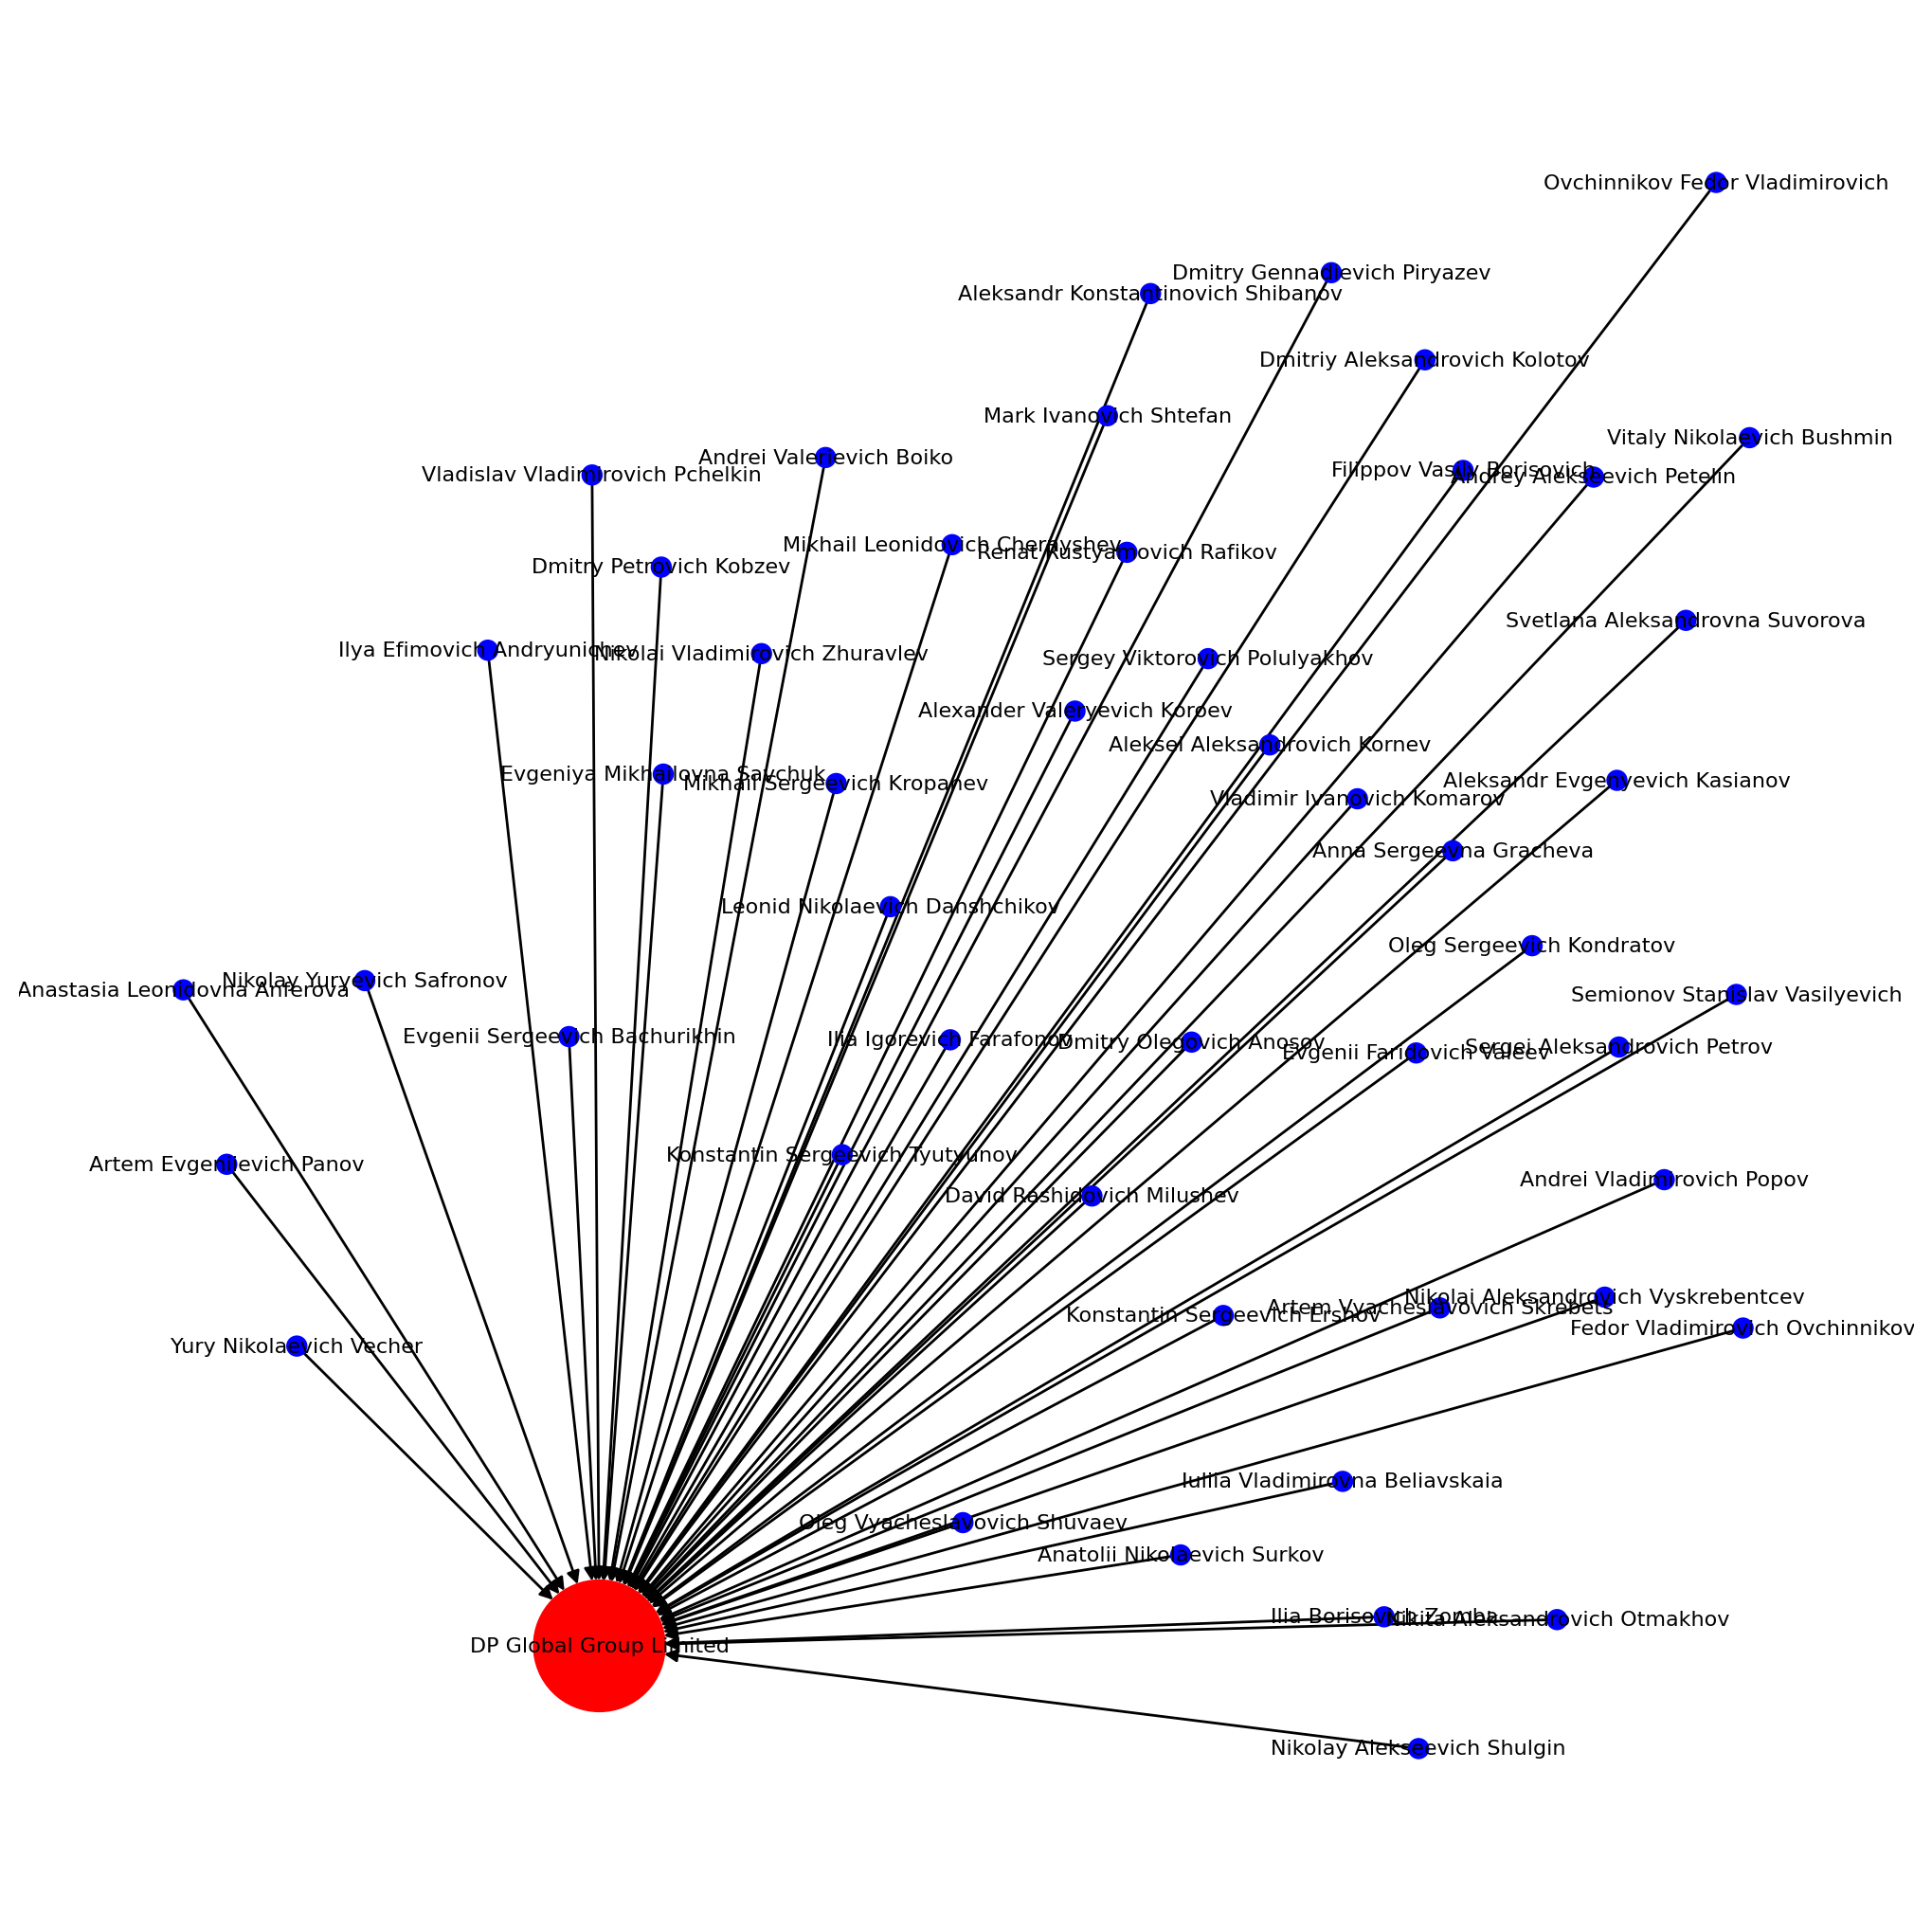

In [91]:
# get the entity with the most connections
entity_degrees = G.degree(nodes_entities_new["node_id"])
max_entity = max(entity_degrees, key=lambda x: x[1])
print(f"Entity with most connections: {G.nodes[max_entity[0]]['name']} with {max_entity[1]} connections")

# draw ego graph of entity with most connections
plt.figure(figsize=(10, 10), dpi=200)
ego_graph = nx.ego_graph(G, max_entity[0], radius=1, undirected=True)
colors = [color_map[G.nodes[node]["node_type"]] for node in ego_graph.nodes]
sizes = [G.degree[node]*50 for node in ego_graph.nodes]
labels = {node: G.nodes[node]["name"] for node in ego_graph.nodes}
nx.draw(ego_graph, with_labels=True, node_color=colors, node_size=sizes, labels=labels, font_size=8)

Officer with most connections: Sharecorp Limited with 1098 connections


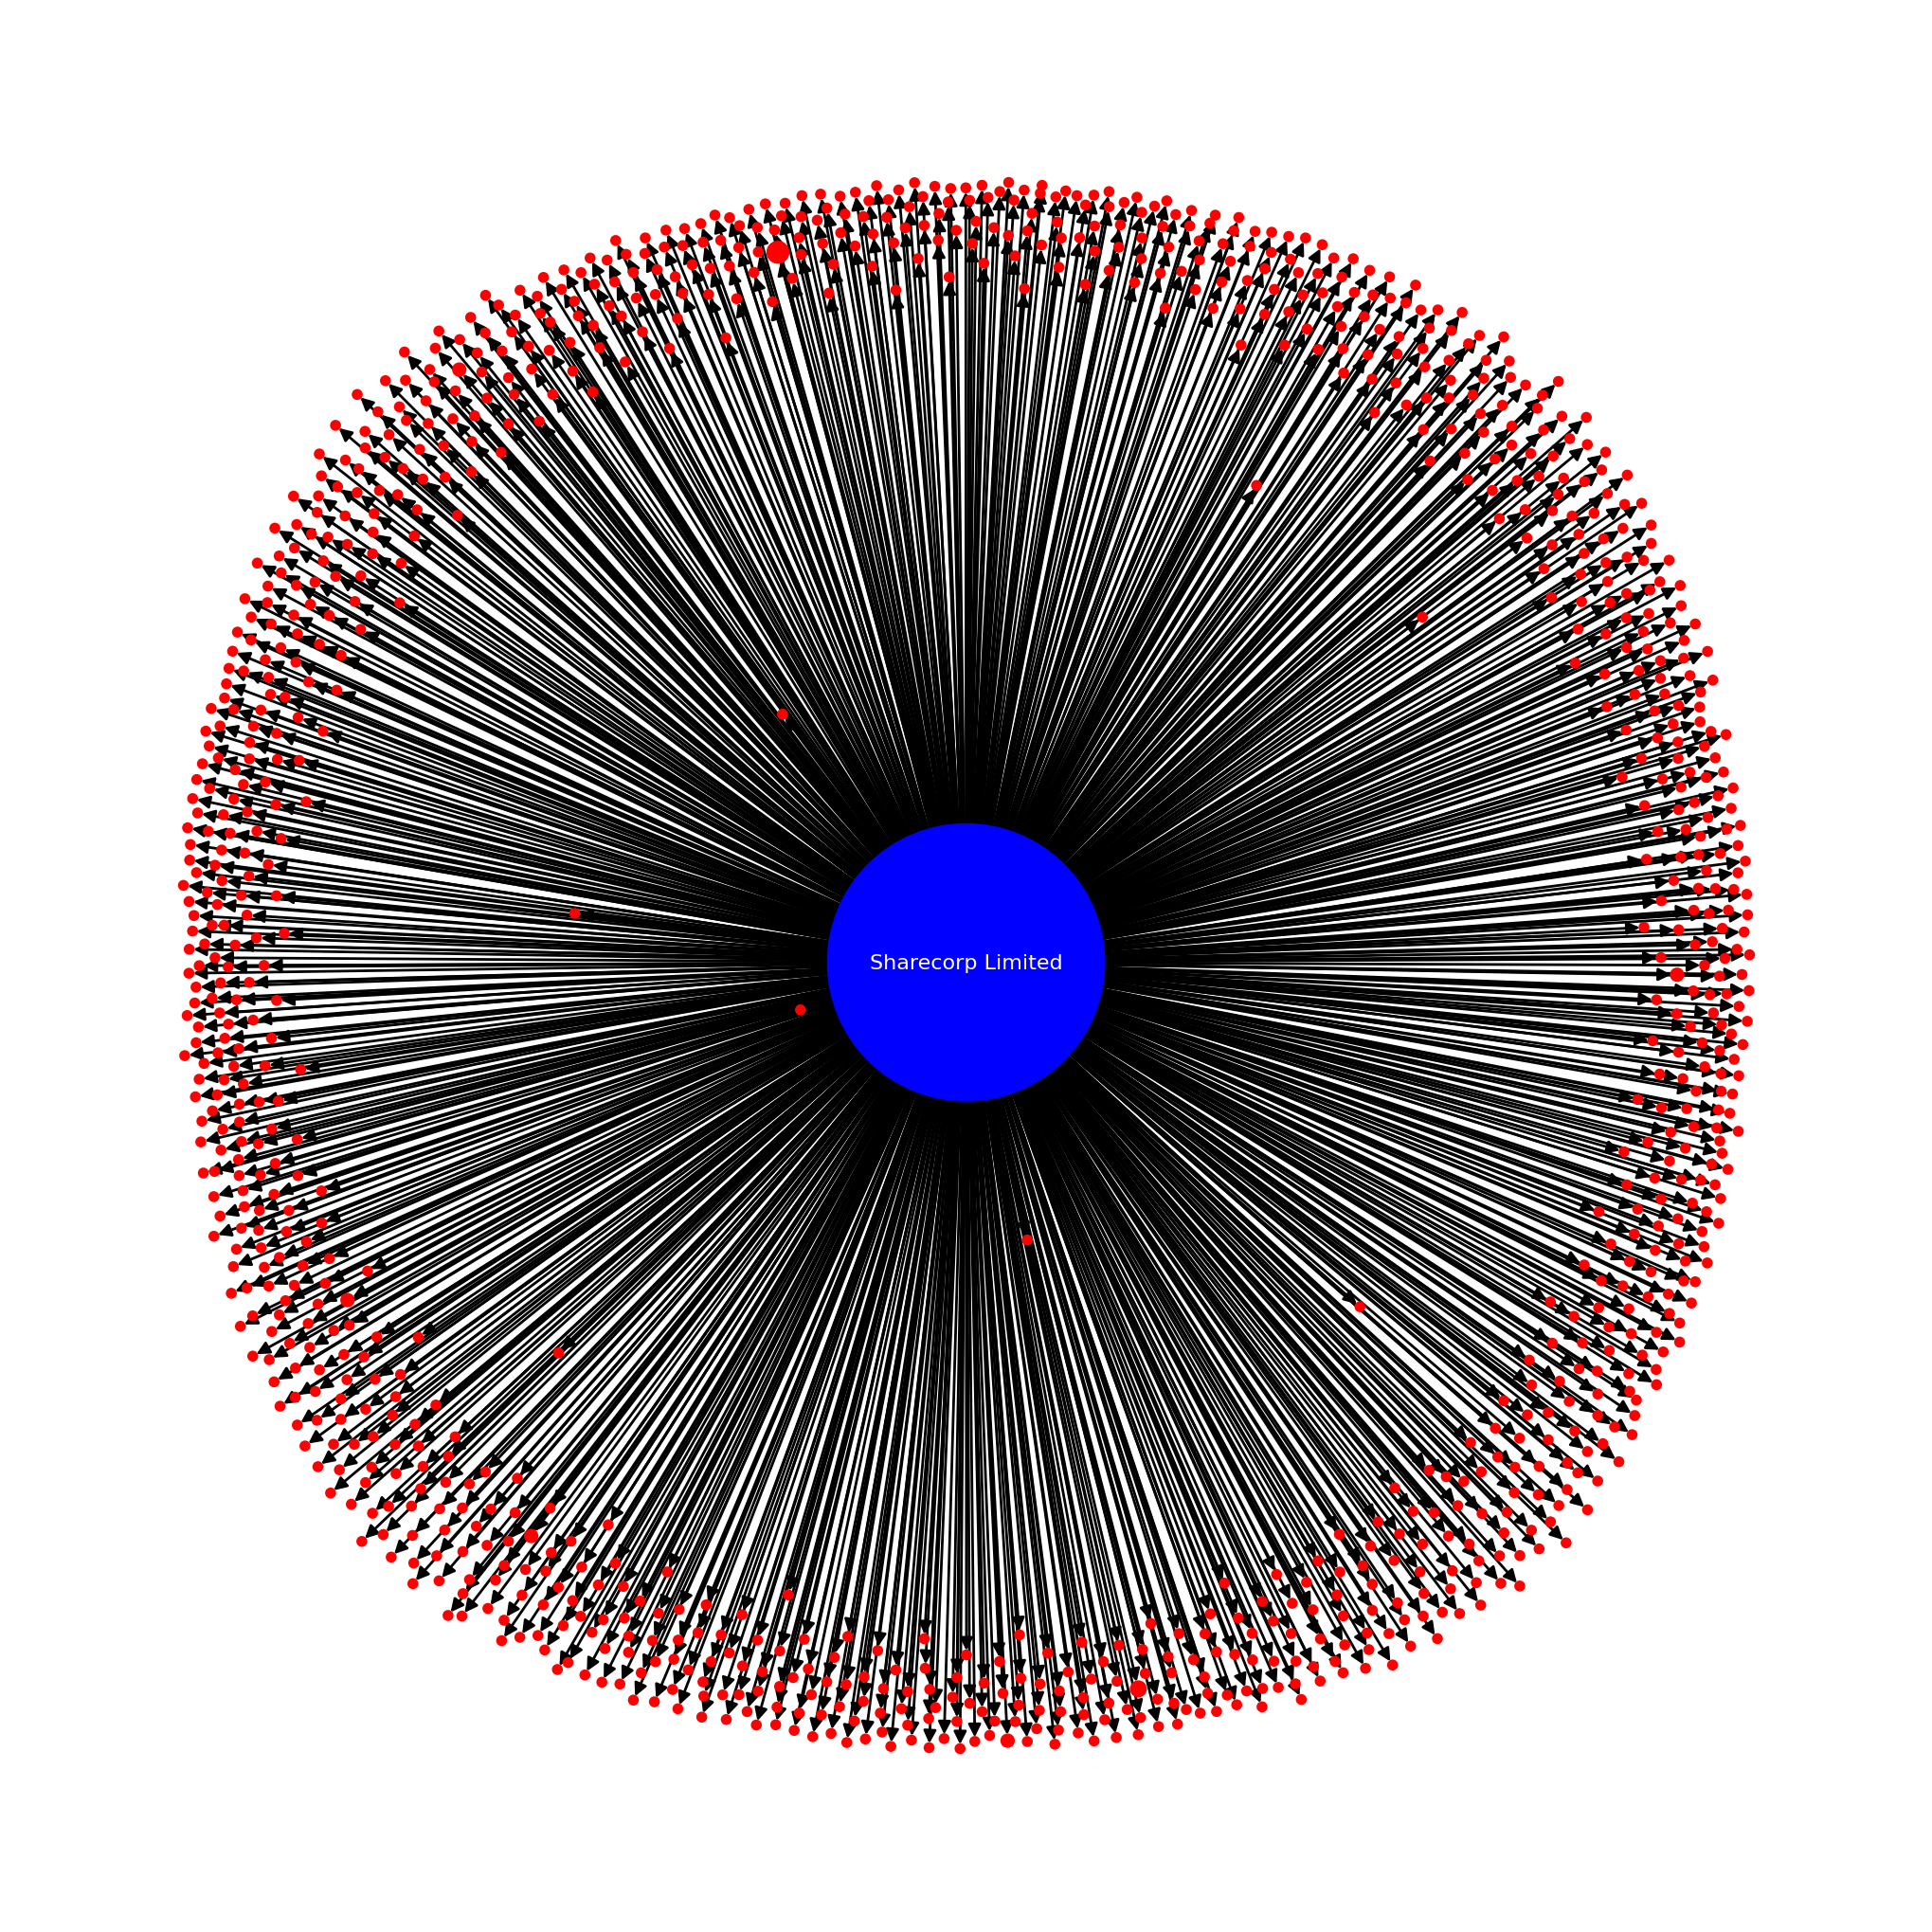

In [88]:
# get the officer with the most connections
officer_degrees = G.degree(nodes_officers_new["node_id"])
max_officer = max(officer_degrees, key=lambda x: x[1])
print(f"Officer with most connections: {G.nodes[max_officer[0]]['name']} with {max_officer[1]} connections")

# draw ego graph of officer with most connections
plt.figure(figsize=(10, 10), dpi=200)
ego_graph = nx.ego_graph(G, max_officer[0], radius=1) 
colors = [color_map[G.nodes[node]["node_type"]] for node in ego_graph.nodes]
sizes = [G.degree(node)*10 for node in ego_graph.nodes]
labels = {node: "" if node != max_officer[0] else G.nodes[node]["name"] for node in ego_graph.nodes}
nx.draw(ego_graph, with_labels=True, node_color=colors, node_size=sizes, labels=labels, font_size=8, font_color="white")

Officer with most connections: Evgenii Faridovich Valeev with 48 connections


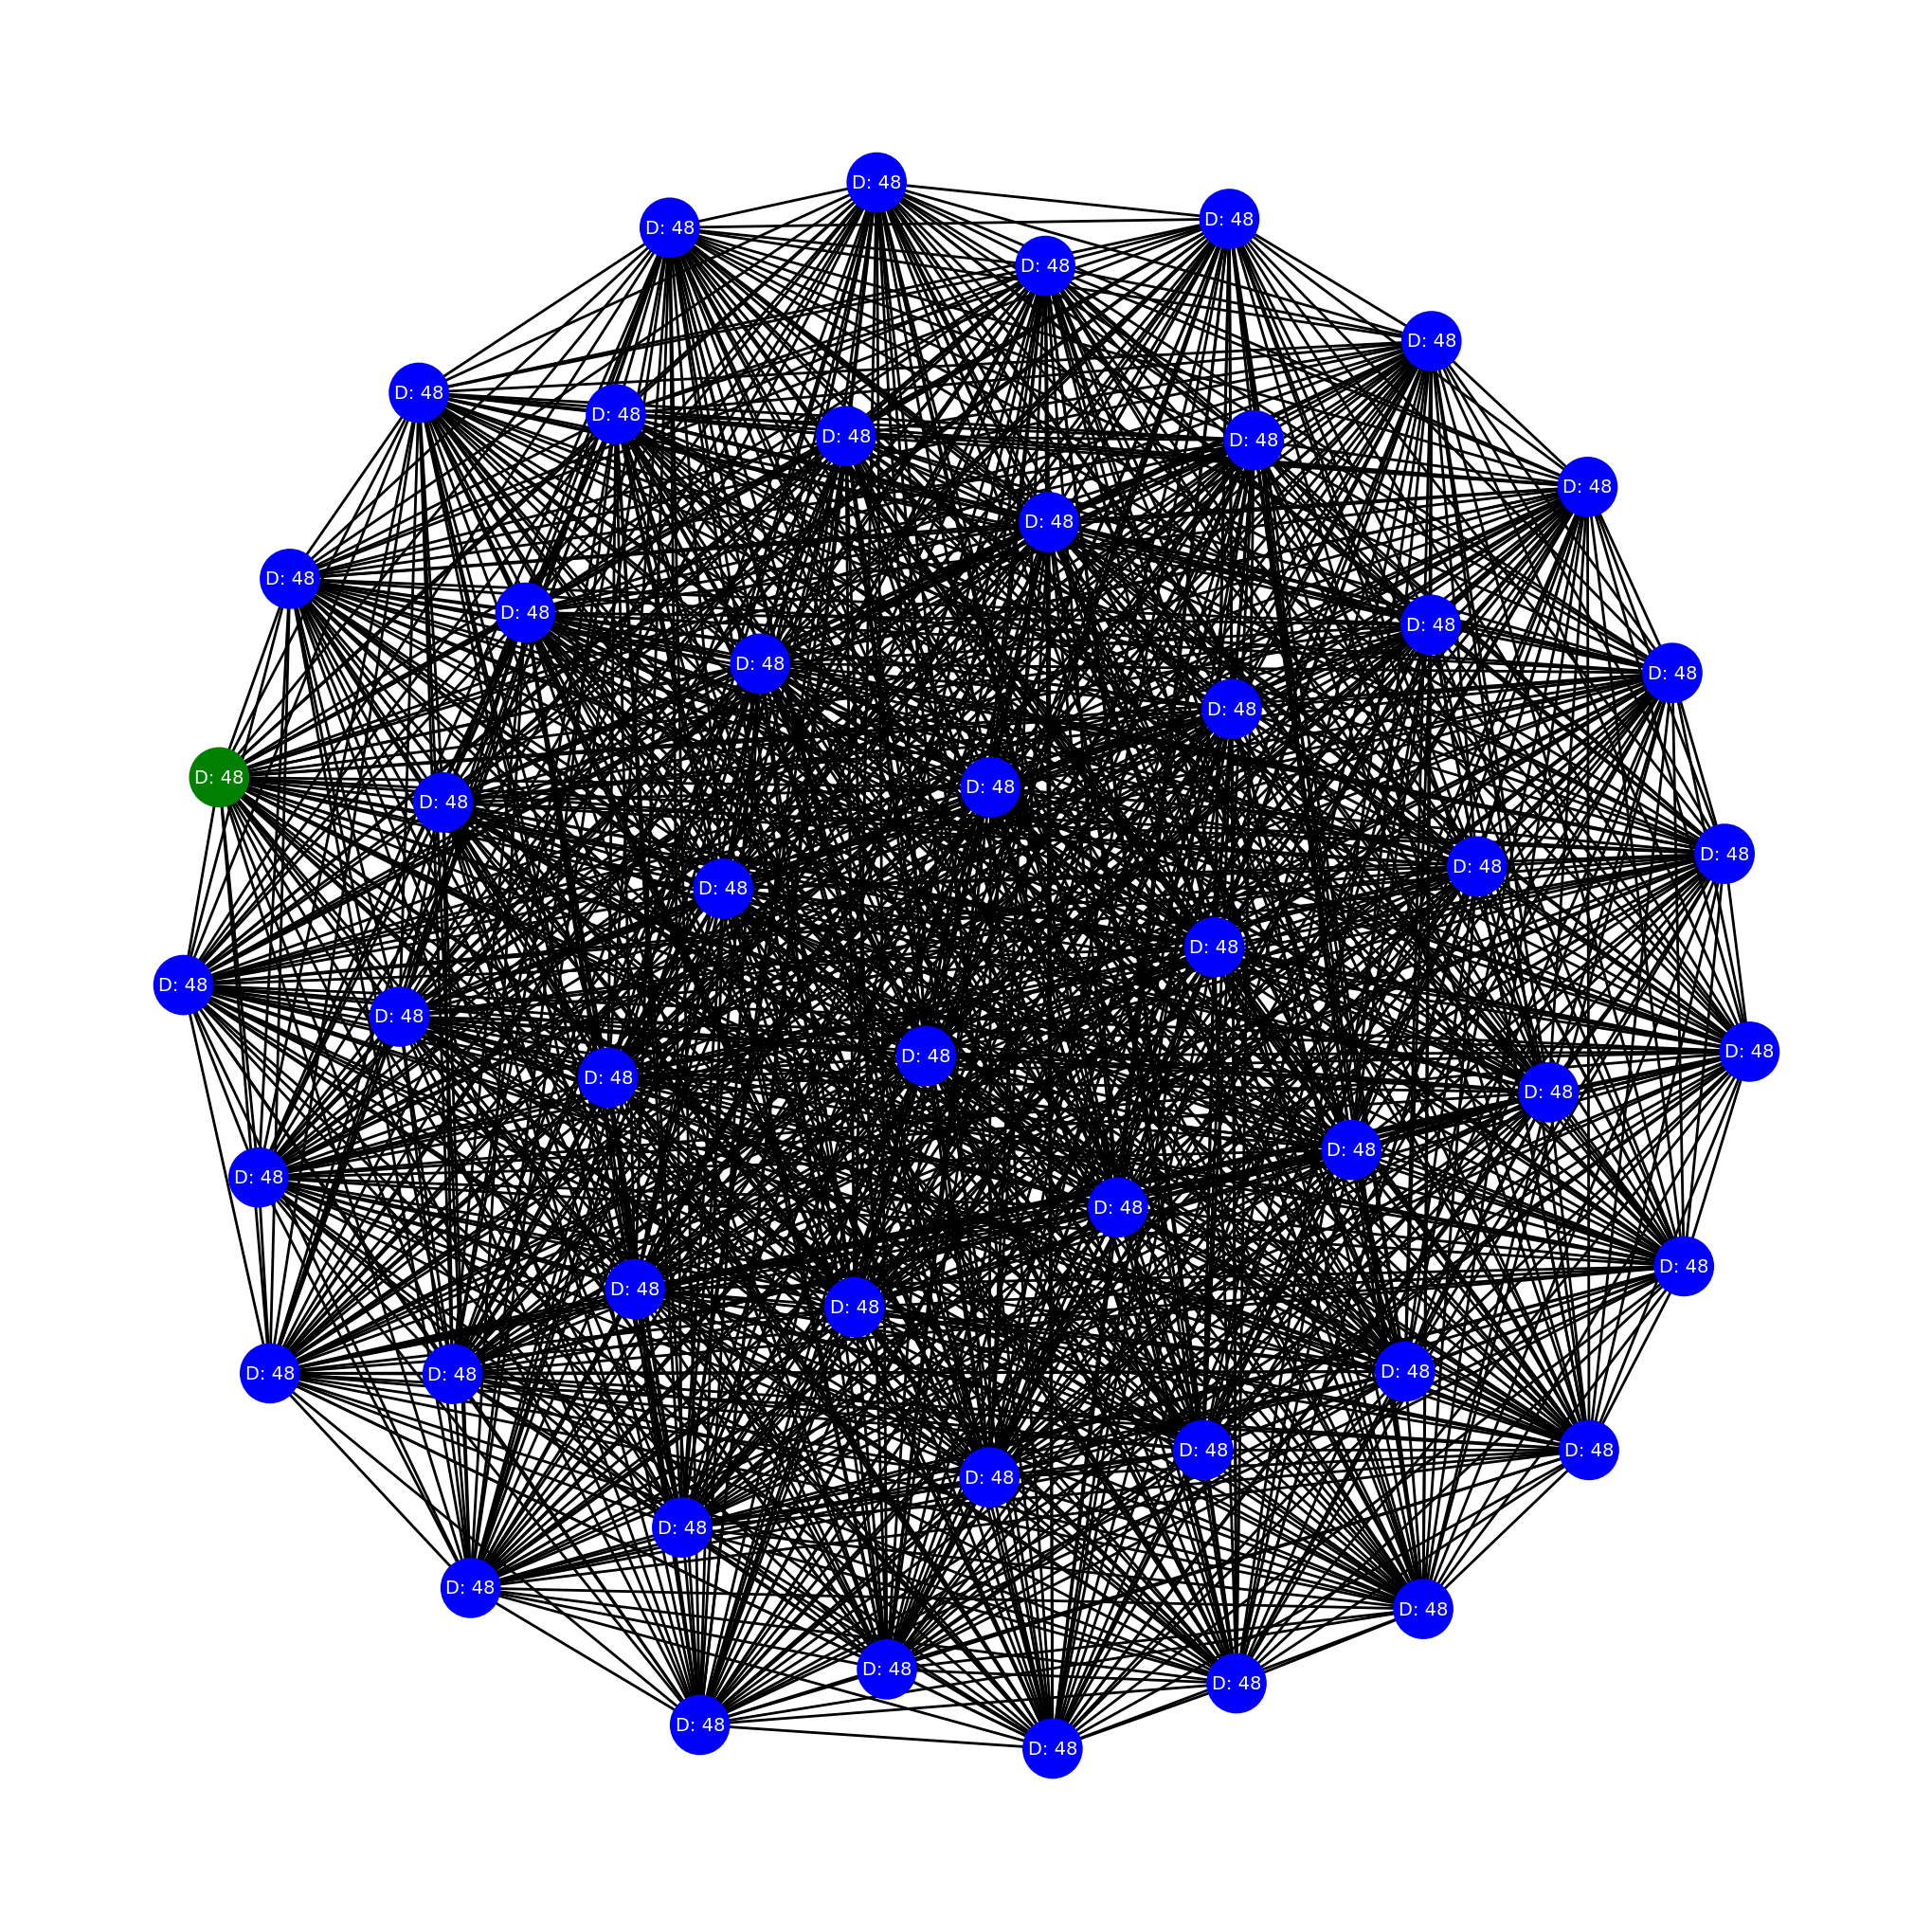

In [92]:
B = nx.bipartite.weighted_projected_graph(G.to_undirected(), nodes_officers_new["node_id"], ratio=True)

# get the officer with the most connections
officer_degrees = B.degree(nodes_officers_new["node_id"])
max_officer = max(officer_degrees, key=lambda x: x[1])
print(f"Officer with most connections: {B.nodes[max_officer[0]]['name']} with {max_officer[1]} connections")

# draw ego graph of officer with most connections
plt.figure(figsize=(10, 10), dpi=200)
ego_graph = nx.ego_graph(B, max_officer[0], radius=1)
pos = nx.spring_layout(ego_graph)
colors = ["green" if node == max_officer[0] else color_map[B.nodes[node]["node_type"]] for node in ego_graph.nodes()]
sizes = [B.degree(node)*10 for node in ego_graph.nodes]
labels = {node: f"D: {B.degree(node)}" for node in ego_graph.nodes()}
nx.draw(ego_graph, pos, with_labels=True, node_color=colors, node_size=sizes, labels=labels, font_size=7, font_color="white")